In [2]:
import fastavro
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
avro_file = 'songs_advanced.avro'

with open(avro_file, 'rb') as f:
    avro_data = list(fastavro.reader(f))

df = pd.DataFrame.from_records(avro_data)

columns_to_fill = ['bar_num','beat_num','segments_loudness_max_time_mean','artist_familiarity', 'key','duration', 'end_of_fade_in', 'loudness', 'tempo', 'time_signature']

df[columns_to_fill] = df[columns_to_fill].fillna(df[columns_to_fill].mean())

df_selected = df.loc[:,columns_to_fill]


# K-mean

## Model training

In [4]:
k = 200 

kmeans = KMeans(n_clusters=k)
kmeans.fit(df_selected)

cluster_centers = kmeans.cluster_centers_

labeled_df = df.copy()
labeled_df['Cluster'] = kmeans.labels_

# Visualization by PCA

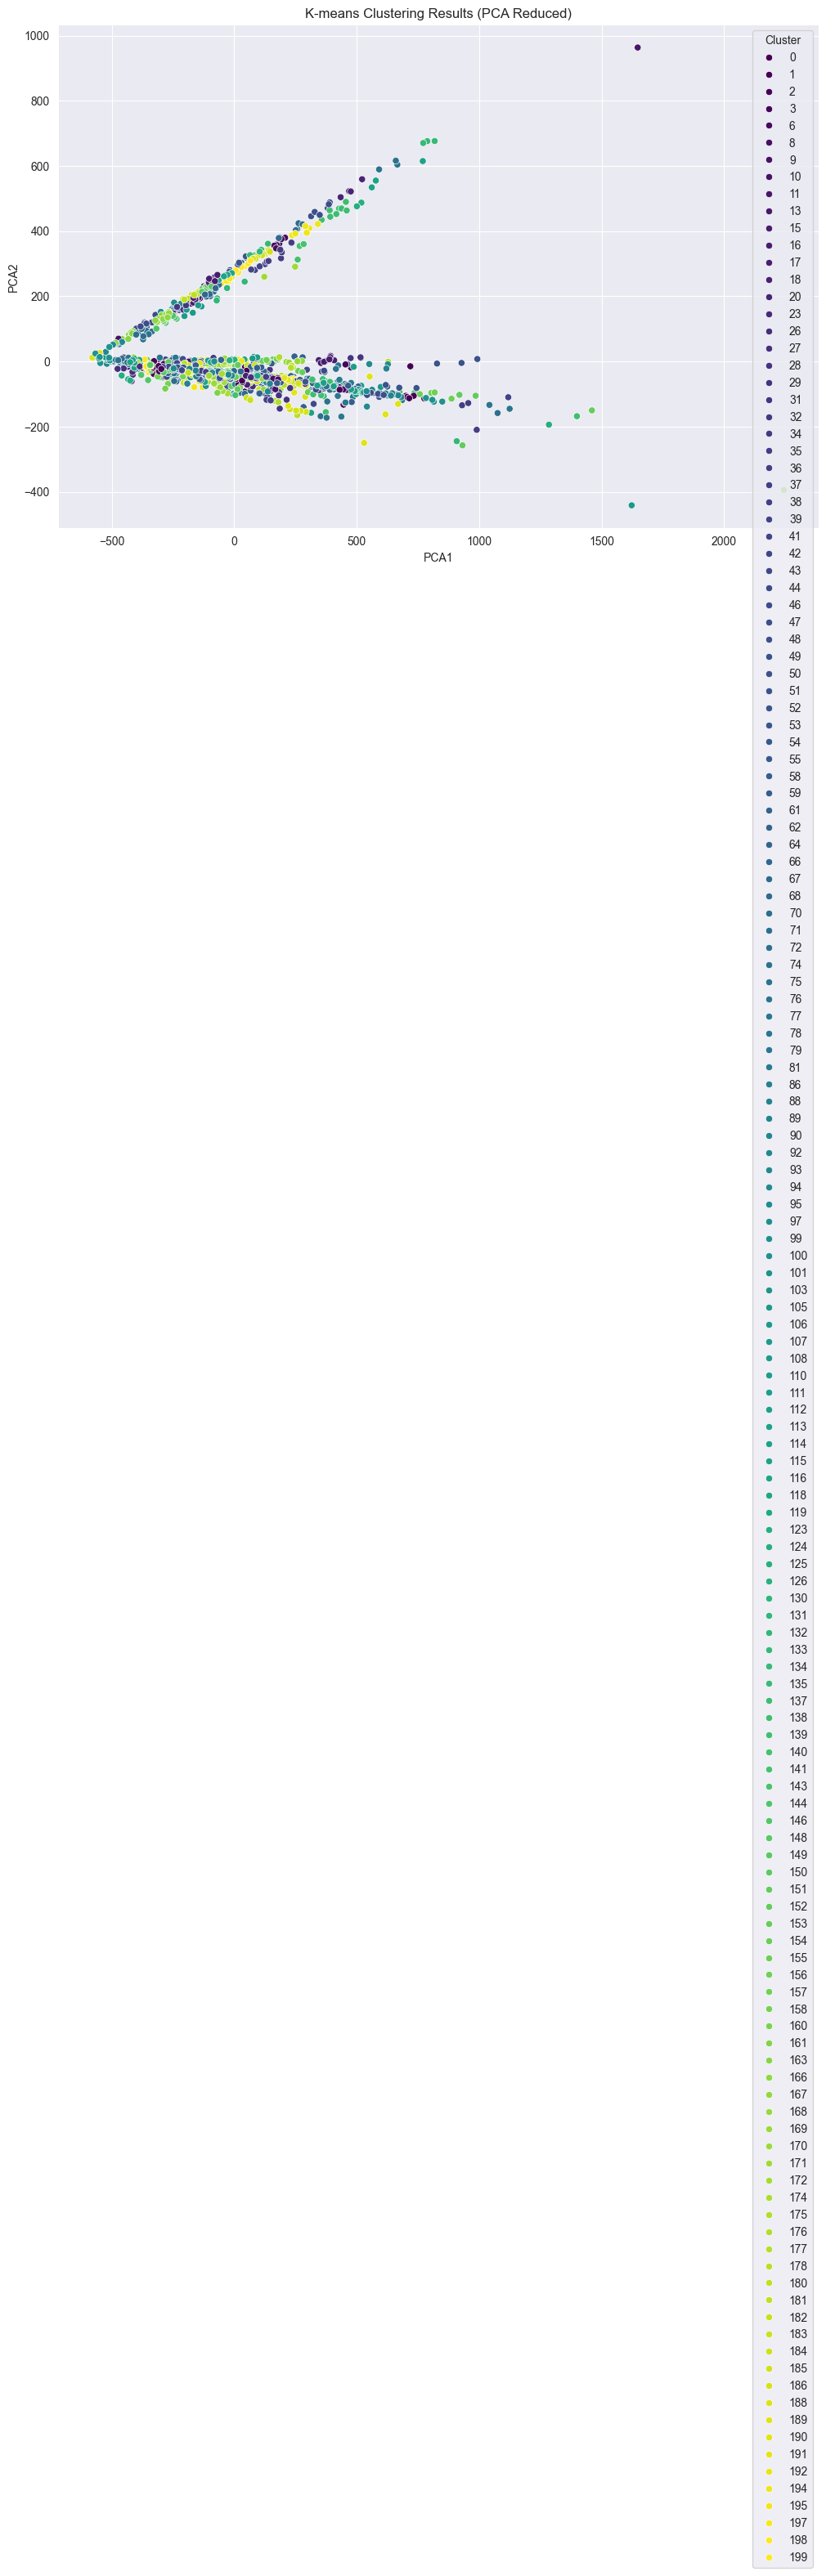

In [5]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_selected)

# 创建一个新的DataFrame用于可视化
visual_df = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])
visual_df['Cluster'] = labeled_df['Cluster']

# 随机采样（如果数据点过多）
sample_size = 2000  # 设置采样大小，根据需要调整
if len(visual_df) > sample_size:
    visual_df = visual_df.sample(n=sample_size, random_state=42)
    
# 绘制聚类结果
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PCA1', y='PCA2', 
    hue='Cluster', 
    palette='viridis', 
    data=visual_df,
    legend='full'
)
plt.title('K-means Clustering Results (PCA Reduced)')
plt.show()

## Get the most k related center

In [16]:
def getKMostRelatedCenter(song_id, labeled_df, cluster_centers, k=3)-> list:
    if song_id in labeled_df["song_id"].values:
        print(f"exists.")
        # 继续进行相似度计算
    else:
        print(f"Track ID {song_id} does not exist in the dataset.")
        
    song = labeled_df[labeled_df["song_id"] == song_id]
    
    song = song.loc[:,columns_to_fill].to_numpy()
    
    dis = []
    for center in cluster_centers:
        dis.append(np.dot(song, center) / (np.linalg.norm(song) * np.linalg.norm(center)))
    #print("Dis list:", dis)
    
    sorted_np = np.argsort(np.array(dis), axis=0)[:,0] < k
    index = range(0, np.shape(cluster_centers)[0])

    clusterindex = np.hstack((cluster_centers, np.array(index).reshape(-1, 1)))
    selected_centers = clusterindex[sorted_np][:, -1]

    return list(selected_centers)

In [17]:
k = 10
song_id = b'SOCIWDW12A8C13D406'
related_centers = getKMostRelatedCenter(song_id, labeled_df, cluster_centers, k)

exists.


In [18]:
df_related = labeled_df[labeled_df["Cluster"].isin(related_centers)]

In [19]:
features = df_related.loc[:,columns_to_fill].to_numpy()

song = labeled_df[labeled_df["song_id"] == song_id]
song_numpy = song.loc[:,columns_to_fill].to_numpy()

song_numpy_duplicate = np.tile(song_numpy, (features.shape[0], 1))
cos_numpy = np.transpose(np.dot(features, np.transpose(song_numpy))) / np.transpose(np.linalg.norm(features, axis=1)) / np.transpose(np.linalg.norm(song_numpy_duplicate, axis=1))
cos_numpy = np.transpose(cos_numpy)

df_related["Cos_correlation_factor"] = cos_numpy


C:\Users\oscar meng\AppData\Local\Temp\ipykernel_16444\3549728774.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_related["Cos_correlation_factor"] = cos_numpy


In [20]:
def selected_related(df : pd.DataFrame):
    n = 1
    return (df.sort_values(by= "Cos_correlation_factor", ascending=False).iloc[:n, :])

df_related.groupby(by = "Cluster").apply(selected_related)
     

C:\Users\oscar meng\AppData\Local\Temp\ipykernel_16444\1708129794.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_related.groupby(by = "Cluster").apply(selected_related)


,,loudness,segments_loudness_max_mean,segments_loudness_max_time_mean,artist_7digitalid,time_signature,time_signature_confidence,segments_confidence_mean,artist_familiarity,segments_pitches_mean,segments_start_mean,...,artist_latitude,artist_terms_weight_mean,artist_terms_freq_mean,song_id,title,album_id,album_name,year,Cluster,Cos_correlation_factor
Cluster,,,,,,,,,,,,,,,,,,,,,,
6,838612,-22.610001,-29.597265,0.132925,18857,1.0,0.607,0.260411,0.526495,0.290567,117.624123,...,NaN,0.673710,0.572519,b'SOJDBKS12A6D4F9872',b'Two Voices',27302,b'Drawn From Life',2001.0,6,0.866784
28,440462,-9.235000,-14.103147,0.032158,293405,4.0,0.616,0.672609,0.478877,0.393149,113.631004,...,NaN,0.715187,0.607328,b'SOOQVIL12AAF3B31DC',b'Everything Is Green ',382394,b'Everything Is Green',2004.0,28,0.981397
47,665329,-20.860001,-27.348322,0.080791,78633,4.0,0.605,0.420533,0.538697,0.421492,751.669556,...,29.760450,0.722943,0.672567,b'SOUAWHK12A6D4FB9DD',b'Beautiful Soop (1966)',175510,b'Alien Bog / Beautiful Soop',1997.0,47,0.950632
80,678205,-6.446000,-10.042576,0.048645,14853,4.0,0.580,0.488779,0.568064,0.264583,82.680214,...,NaN,0.760748,0.696425,b'SOYONRY12A6D4FA815',b'King Of The Town',57486,b'The Place Where You Will Find Us',2002.0,80,0.998218
103,446133,-31.716000,-34.184887,0.097505,166930,1.0,1.000,0.325266,0.643163,0.427351,1333.942139,...,29.760450,0.823618,0.681013,b'SOGNACS12A8C140DBA',b'Variation #9: Pantelleria',220126,b'Variations For Piano & Tape',2006.0,103,0.825287
125,804439,-5.907000,-10.286313,0.031235,82238,4.0,1.000,0.779343,0.810506,0.401843,229.643295,...,40.655071,0.410894,0.219694,b'SOPKKJH12AB018E91A',b'Leelou (LMC Remix)',719655,b'Best of HSOLA 2009',0.0,125,0.976981
136,403769,-7.130000,-11.921936,0.045565,174982,1.0,0.258,0.493794,0.426948,0.434815,49.839104,...,NaN,0.750601,0.695730,b'SOYALRH12AC9071923',b'Babylon(e)',602304,b'Dogma',0.0,136,0.896025
152,199587,-8.319000,-10.418979,0.053156,179841,4.0,0.811,0.663542,0.524486,0.348884,75.437447,...,33.523060,0.661933,0.635863,b'SOOWOFJ12A8C138EA4',"b""I Was Tellin' Him About You""",262484,b'A Lady In The Street',0.0,152,0.999664
165,735520,-5.819000,-7.975724,0.069558,541908,5.0,0.867,0.424611,0.354940,0.305659,519.623901,...,NaN,0.639502,0.599818,b'SOETEPE12AB018BB16',b'Anne',727283,b'...tot licht !',2003.0,165,0.940049


In [21]:
labeled_df[labeled_df["song_id"] == song_id]

,loudness,segments_loudness_max_mean,segments_loudness_max_time_mean,artist_7digitalid,time_signature,time_signature_confidence,segments_confidence_mean,artist_familiarity,segments_pitches_mean,segments_start_mean,...,artist_longitude,artist_latitude,artist_terms_weight_mean,artist_terms_freq_mean,song_id,title,album_id,album_name,year,Cluster
4,-9.843,-12.450609,0.054163,1998,4.0,0.384,0.698873,0.63063,0.296259,72.893227,...,-90.04892,35.149681,0.671166,0.646709,b'SOCIWDW12A8C13D406',b'Soul Deep',300822,b'Dimensions',1969.0,166
